Cerberus Residential Opportunities Data Science Role

Project Description:
As a large Single Family Rental (SFR) operator in the US with properties across the country, one of our most
important objectives is to determine the "Market Rent" estimate for a given property. An accurate "Market Rent"
estimate allows us to rent out properties quickly and fairly and informs the rent at which we send out renewal
offers. However, discrepancies between markets, neighborhoods, and properties make this a non-trivial problem.

Your task is to create an algorithm in Python that can calculate a "Market Rent" estimate for a property given
its location and some common property attributes. Your model will be trained on the rent level at which nearby
properties were rented out over the past two years. A test set is provided, but your model should be able to
provide rent estimates for properties outside of the test set as well. Be thoughtful about your approach and be
organized in your train of thought. There is no right answer, we just want to see how you think.

The data that is provided represent dummy, not actual, transactions and properties. However, the distribution of
properties should mirror the actual density of our largest SFR markets.


Data:
TrainingSet.csv and TestSet.csv both contain the following columns -
Latitude
Longitude
Bedrooms
Bathrooms
Square Feet
Year Built

TrainingSet.csv also contains the following columns -
Close Date
Close Price


Deliverable:
Create a function that, given a Pandas Dataframe with Latitude, Longitude, Bedrooms, Bathrooms, Square Feet, and
Year Built, will create a calculated Market Rent column. Please submit in a .ipynb or .py file.

Please include comments as you go and think of ways that you could augment the model. Are there other property
attributes that you think are important? Are there other approaches that you would like to explore given more time?
We want to see everything that you find in the data and support your conclusions with evidence.

Time Limit:
48 Hours

APPENDIX

In [ ]:
#import folium #Long and Lat on US map
import requests, zipfile, io
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib
from sklearn.cluster import KMeans

In [ ]:
train = pd.read_csv('/content/TrainingSet.csv')
display(train.head())

,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
0,12/17/2024,4800.0,26.257621,-81.711571,4,3.0,2259,2004
1,12/17/2024,3700.0,34.041742,-84.044686,5,6.0,2951,2002
2,12/17/2024,2400.0,33.205474,-96.664503,4,2.0,1788,2000
3,12/17/2024,1770.0,27.756995,-82.648477,3,1.0,944,1955
4,12/17/2024,1995.0,32.627490,-97.328963,3,2.0,1360,2010


In [ ]:
#test = pd.read_csv('/content/TestSet.csv')
#display(test.head())

In [ ]:
print("Training Data Info:")
train.info()
print("\nTraining Data Description:")
display(train.describe())
print("\nTraining Data Missing Values:")
display(train.isnull().sum())
print("\nTraining Data Duplicate Rows:")
display(train.duplicated().sum())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274075 entries, 0 to 274074
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Close Date   274075 non-null  object 
 1   Close Price  274075 non-null  float64
 2   Latitude     274075 non-null  float64
 3   Longitude    274075 non-null  float64
 4   Bedrooms     274075 non-null  int64  
 5   Bathrooms    274075 non-null  float64
 6   Square Feet  274075 non-null  int64  
 7   Year Built   274075 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 16.7+ MB

Training Data Description:


,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
count,274075.000000,274075.000000,274075.000000,274075.000000,274075.000000,2.740750e+05,274075.000000
mean,2347.445740,31.808253,-95.105780,3.448735,2.374001,2.013798e+03,1996.284532
std,816.529811,2.910126,11.778017,0.925106,0.833122,3.299499e+04,20.534975
min,400.000000,25.401486,-115.410772,1.000000,0.100000,-3.600000e+01,1800.000000
25%,1855.000000,29.699736,-97.404022,3.000000,2.000000,1.477000e+03,1985.000000
50%,2195.000000,32.783415,-95.604447,3.000000,2.000000,1.809000e+03,2002.000000
75%,2595.000000,33.647606,-82.782850,4.000000,3.000000,2.238000e+03,2011.000000
max,10000.000000,40.365943,-79.716759,222.000000,205.000000,1.244129e+07,2023.000000



Training Data Missing Values:


,0
Close Date,0
Close Price,0
Latitude,0
Longitude,0
Bedrooms,0
Bathrooms,0
Square Feet,0
Year Built,0



Training Data Duplicate Rows:


np.int64(0)

In [ ]:
# Convert 'Close Date' to datetime and extract year and month for the training data
train['Close Date'] = pd.to_datetime(train['Close Date'], format='%m/%d/%Y')
train['Close Date'] = train['Close Date'].dt.date

display(train.head())

,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
0,2024-12-17,4800.0,26.257621,-81.711571,4,3.0,2259,2004
1,2024-12-17,3700.0,34.041742,-84.044686,5,6.0,2951,2002
2,2024-12-17,2400.0,33.205474,-96.664503,4,2.0,1788,2000
3,2024-12-17,1770.0,27.756995,-82.648477,3,1.0,944,1955
4,2024-12-17,1995.0,32.627490,-97.328963,3,2.0,1360,2010


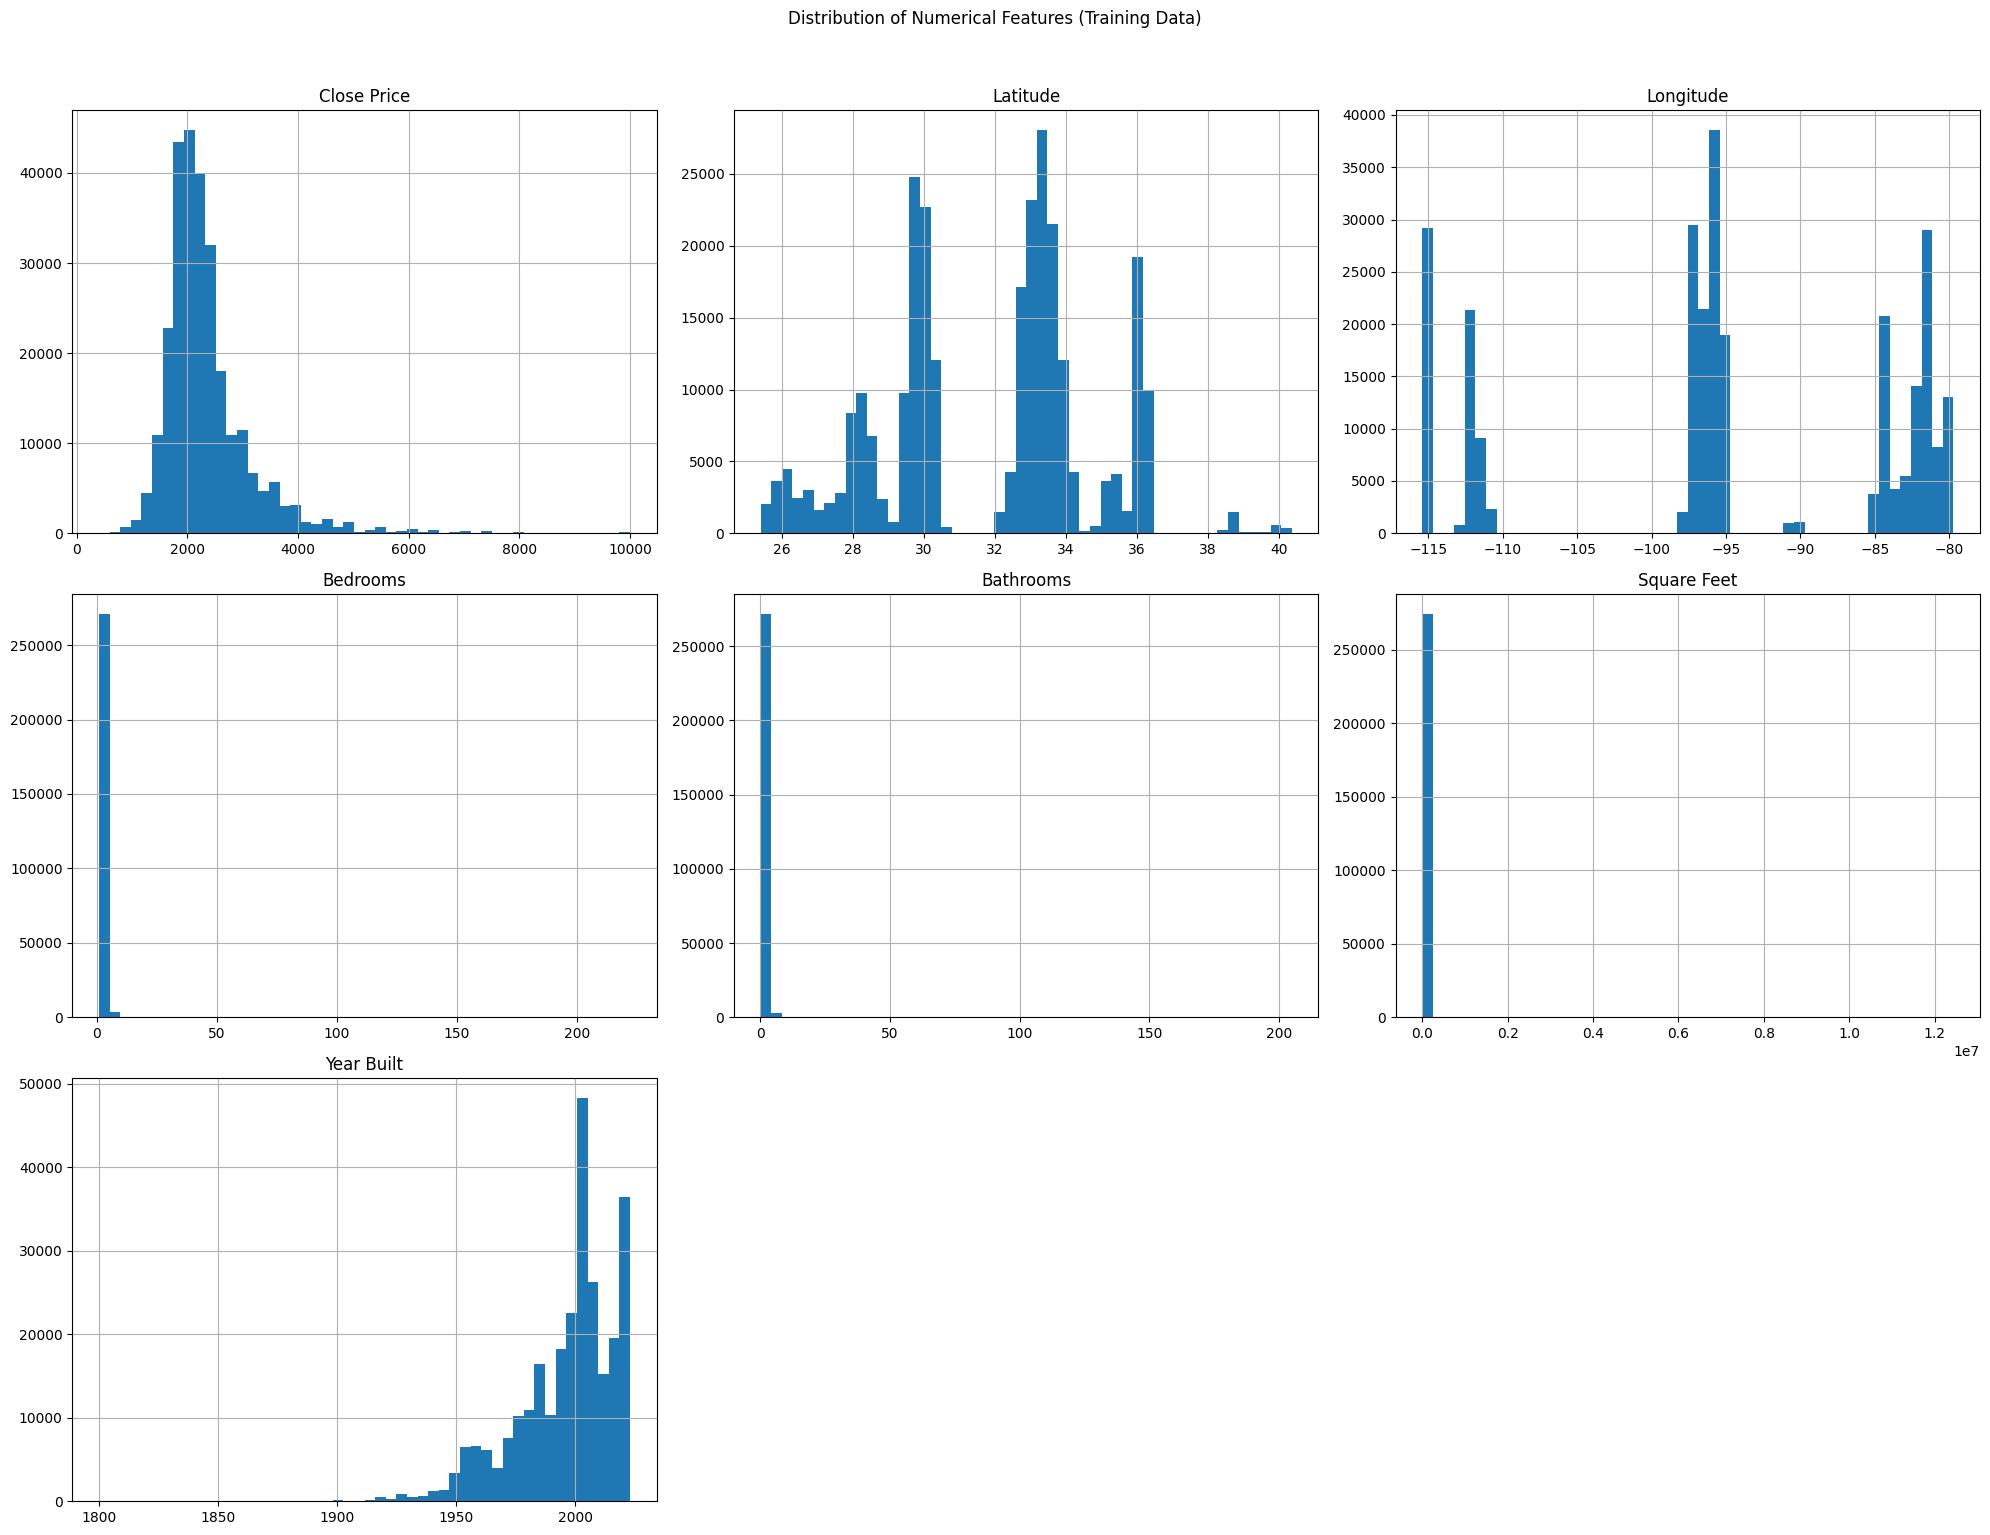

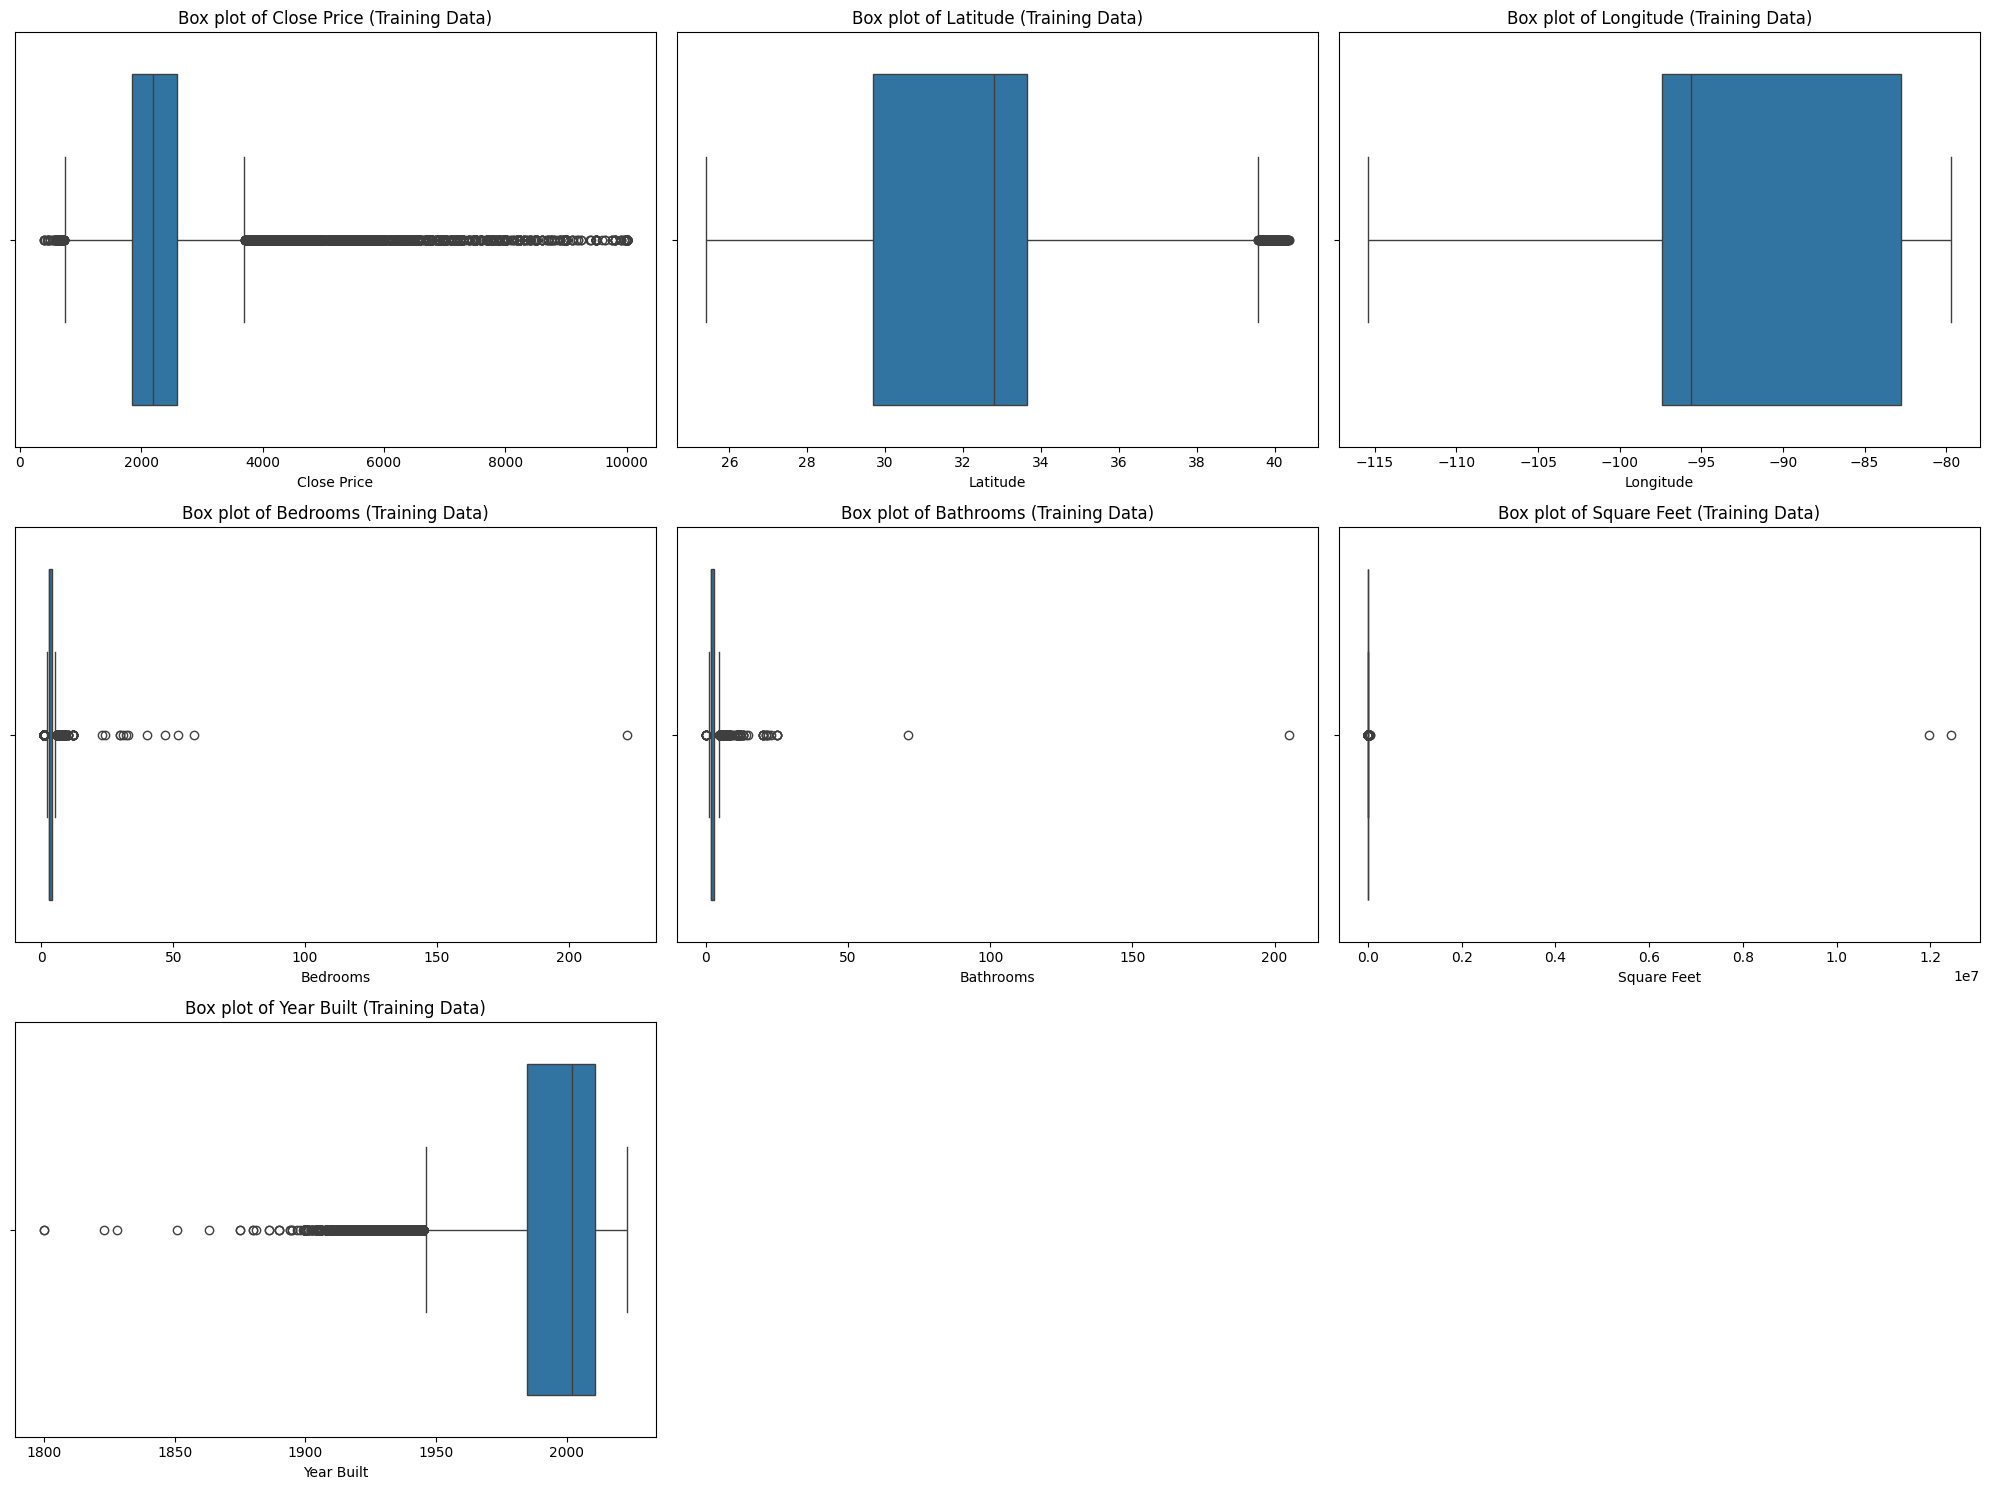

In [ ]:
# Visualize distributions of numerical features in the training data (excluding 'Price per SqFt' for histograms)
numerical_cols_train_hist = ['Close Price', 'Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Square Feet', 'Year Built']
train[numerical_cols_train_hist].hist(bins=50, figsize=(20,15))
plt.suptitle('Distribution of Numerical Features (Training Data)', y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

# Use box plots to visualize potential outliers in the training data (including 'Price per SqFt')
numerical_cols_train_boxplot = ['Close Price', 'Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Square Feet', 'Year Built']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15)) # Adjusted subplot grid for the added column
axes = axes.flatten()

for i, col in enumerate(numerical_cols_train_boxplot):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f'Box plot of {col} (Training Data)')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

In [ ]:
#use the Interquartile Range (IQR) to identify potential outliers programmatically

numerical_cols = ['Close Price', 'Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Square Feet', 'Year Built']
outlier_indices = set()

for col in numerical_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    col_outlier_indices = train[(train[col] < lower_bound) | (train[col] > upper_bound)].index
    outlier_indices.update(col_outlier_indices)

all_outliers = train.loc[list(outlier_indices)]

print("\nPotential outliers across all numerical features (using IQR):")
display(all_outliers)


Potential outliers across all numerical features (using IQR):


,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
262145,2023-02-23,5000.0,34.054722,-84.098712,5,5.0,5898,2004
131081,2024-01-23,6000.0,26.635072,-80.072933,5,4.0,3063,1999
229390,2023-05-24,4100.0,35.499308,-80.887808,4,6.0,4714,2016
163856,2023-11-02,5000.0,27.849670,-82.579487,4,2.0,1963,1970
163860,2023-11-02,5500.0,28.267904,-81.520434,4,4.0,3207,2003
...,...,...,...,...,...,...,...,...
163817,2023-11-02,7000.0,26.324807,-80.252282,5,4.0,3830,2001
163823,2023-11-02,7000.0,26.647831,-80.236191,5,4.0,3100,1988
163827,2023-11-02,5490.0,26.351188,-80.202663,5,5.1,3736,2001
229373,2023-05-24,3600.0,34.044403,-83.912926,5,5.0,5881,2005


In [ ]:
# Remove rows with more than 12 bedrooms or bathrooms
train = train[train['Bedrooms'] <= 12]
train = train[train['Bathrooms'] <= 12]

# Remove bathrooms that do not have a whole number (.0) or half an integer (.5)
train = train[train['Bathrooms'].apply(lambda x: x * 10 % 5 == 0)]

# Remove square feet values <= 0
train = train[train['Square Feet'] > 0]

print("Training data after cleaning:")
display(train)
print("\nTraining data info after cleaning:")
train.info()

Training data after cleaning:


,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
0,2024-12-17,4800.0,26.257621,-81.711571,4,3.0,2259,2004
1,2024-12-17,3700.0,34.041742,-84.044686,5,6.0,2951,2002
2,2024-12-17,2400.0,33.205474,-96.664503,4,2.0,1788,2000
3,2024-12-17,1770.0,27.756995,-82.648477,3,1.0,944,1955
4,2024-12-17,1995.0,32.627490,-97.328963,3,2.0,1360,2010
...,...,...,...,...,...,...,...,...
274070,2023-01-19,2475.0,34.182942,-84.590046,4,3.0,2019,2002
274071,2023-01-19,1735.0,34.018254,-84.794058,4,2.0,1995,2014
274072,2023-01-19,1890.0,33.879067,-84.844168,4,2.0,1893,2017
274073,2023-01-19,2030.0,33.698043,-84.764862,4,3.0,2370,1992



Training data info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 249457 entries, 0 to 274074
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Close Date   249457 non-null  object 
 1   Close Price  249457 non-null  float64
 2   Latitude     249457 non-null  float64
 3   Longitude    249457 non-null  float64
 4   Bedrooms     249457 non-null  int64  
 5   Bathrooms    249457 non-null  float64
 6   Square Feet  249457 non-null  int64  
 7   Year Built   249457 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 17.1+ MB


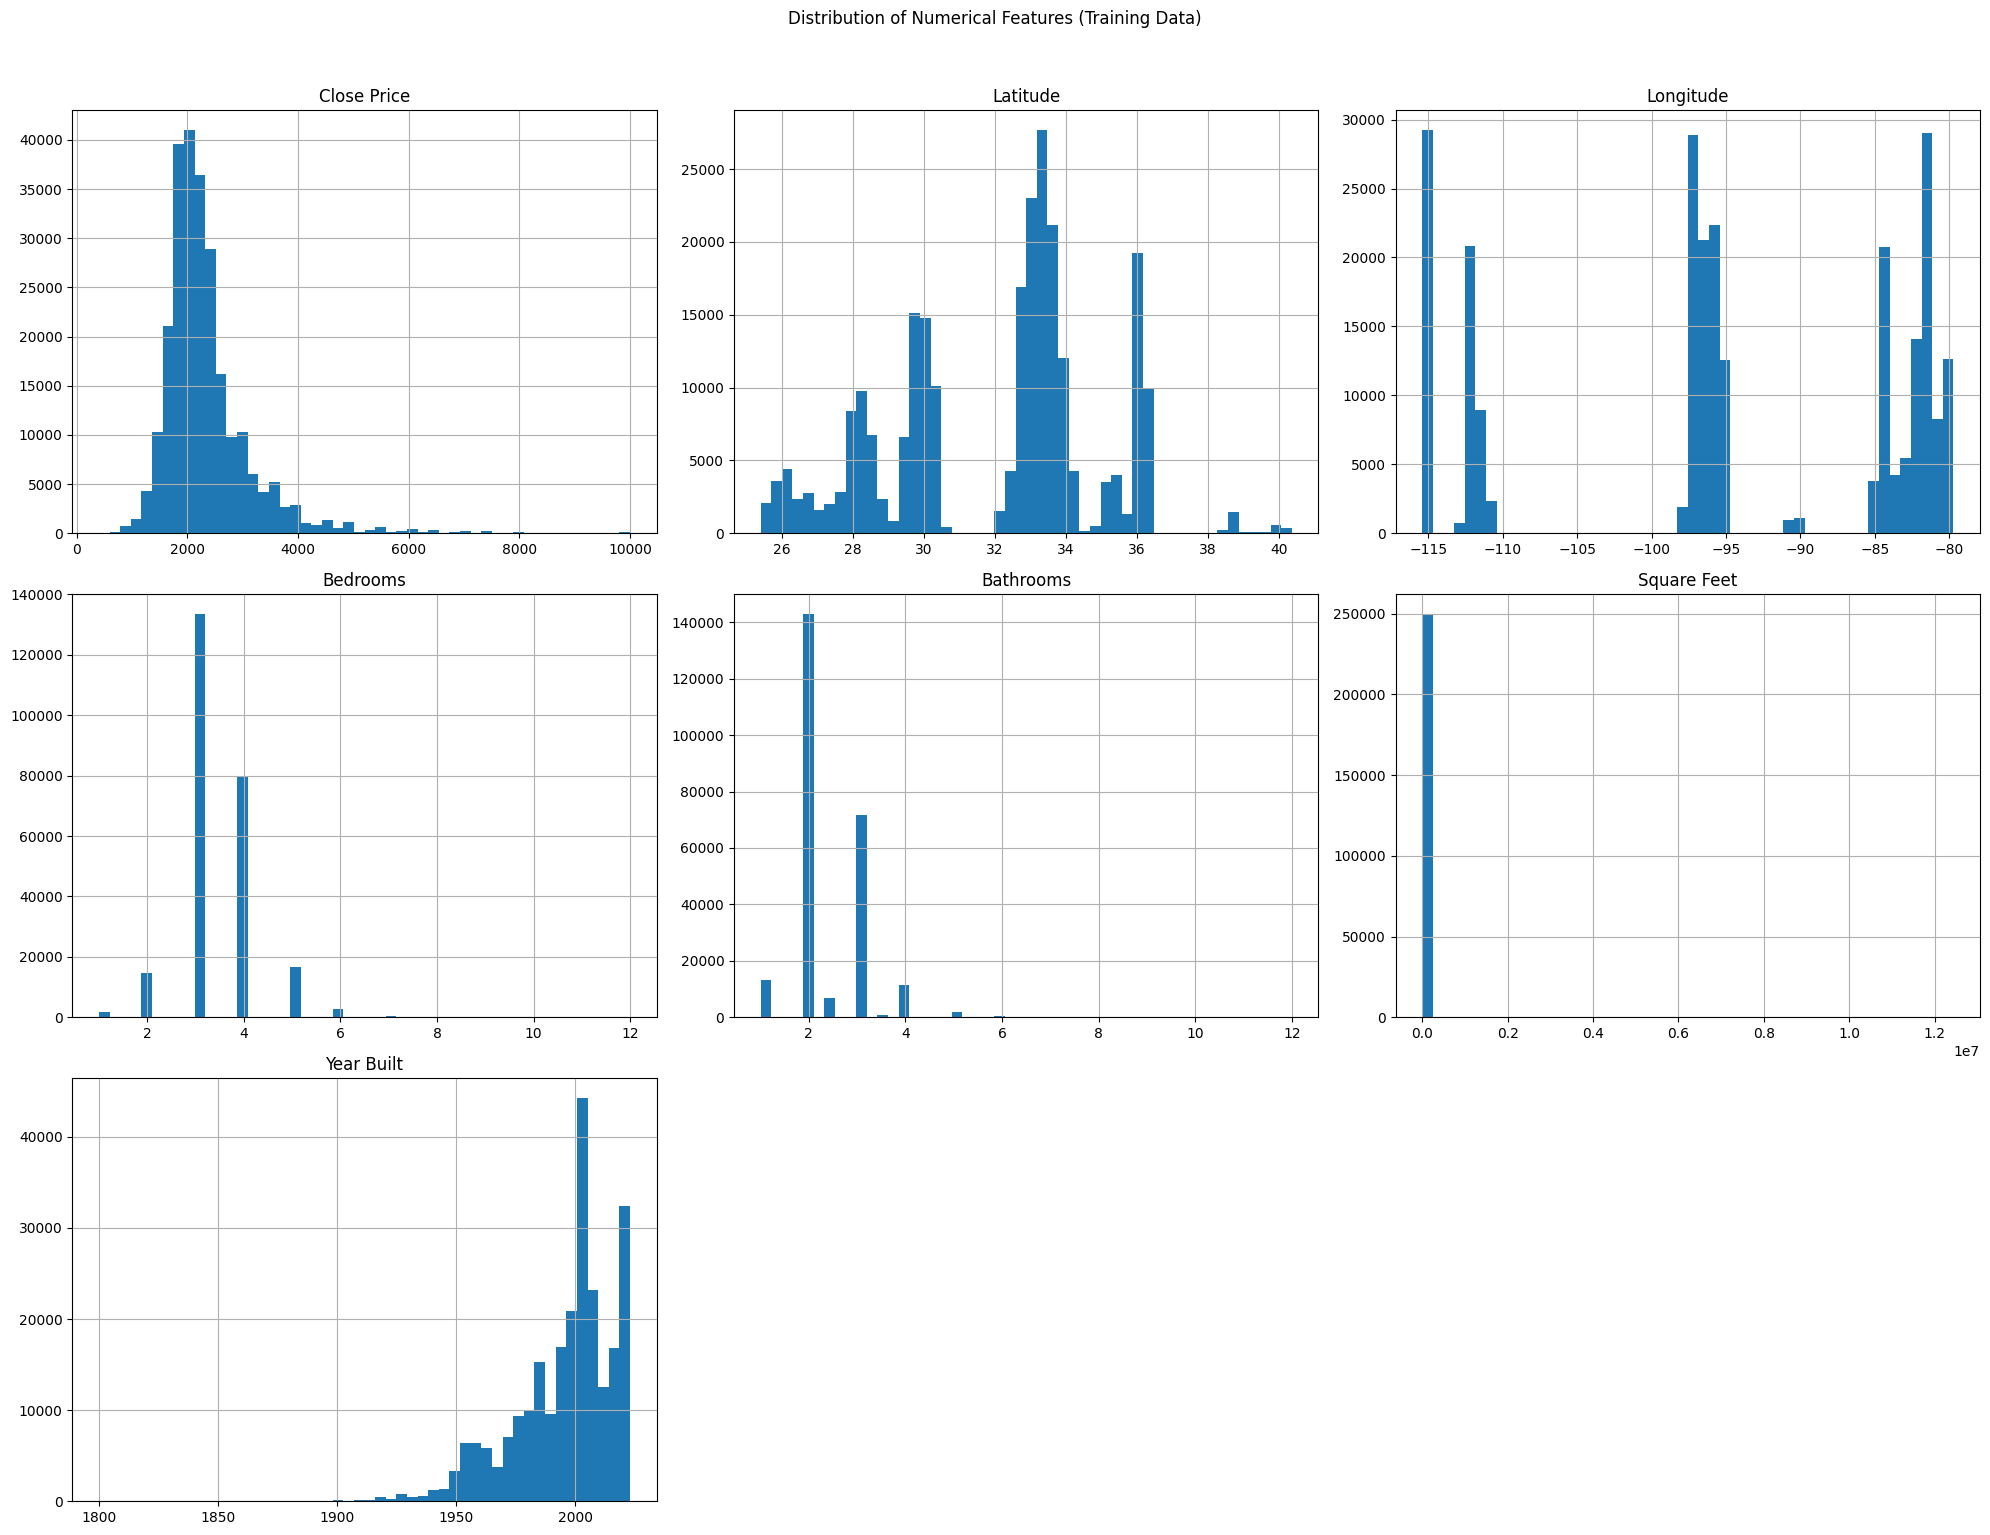

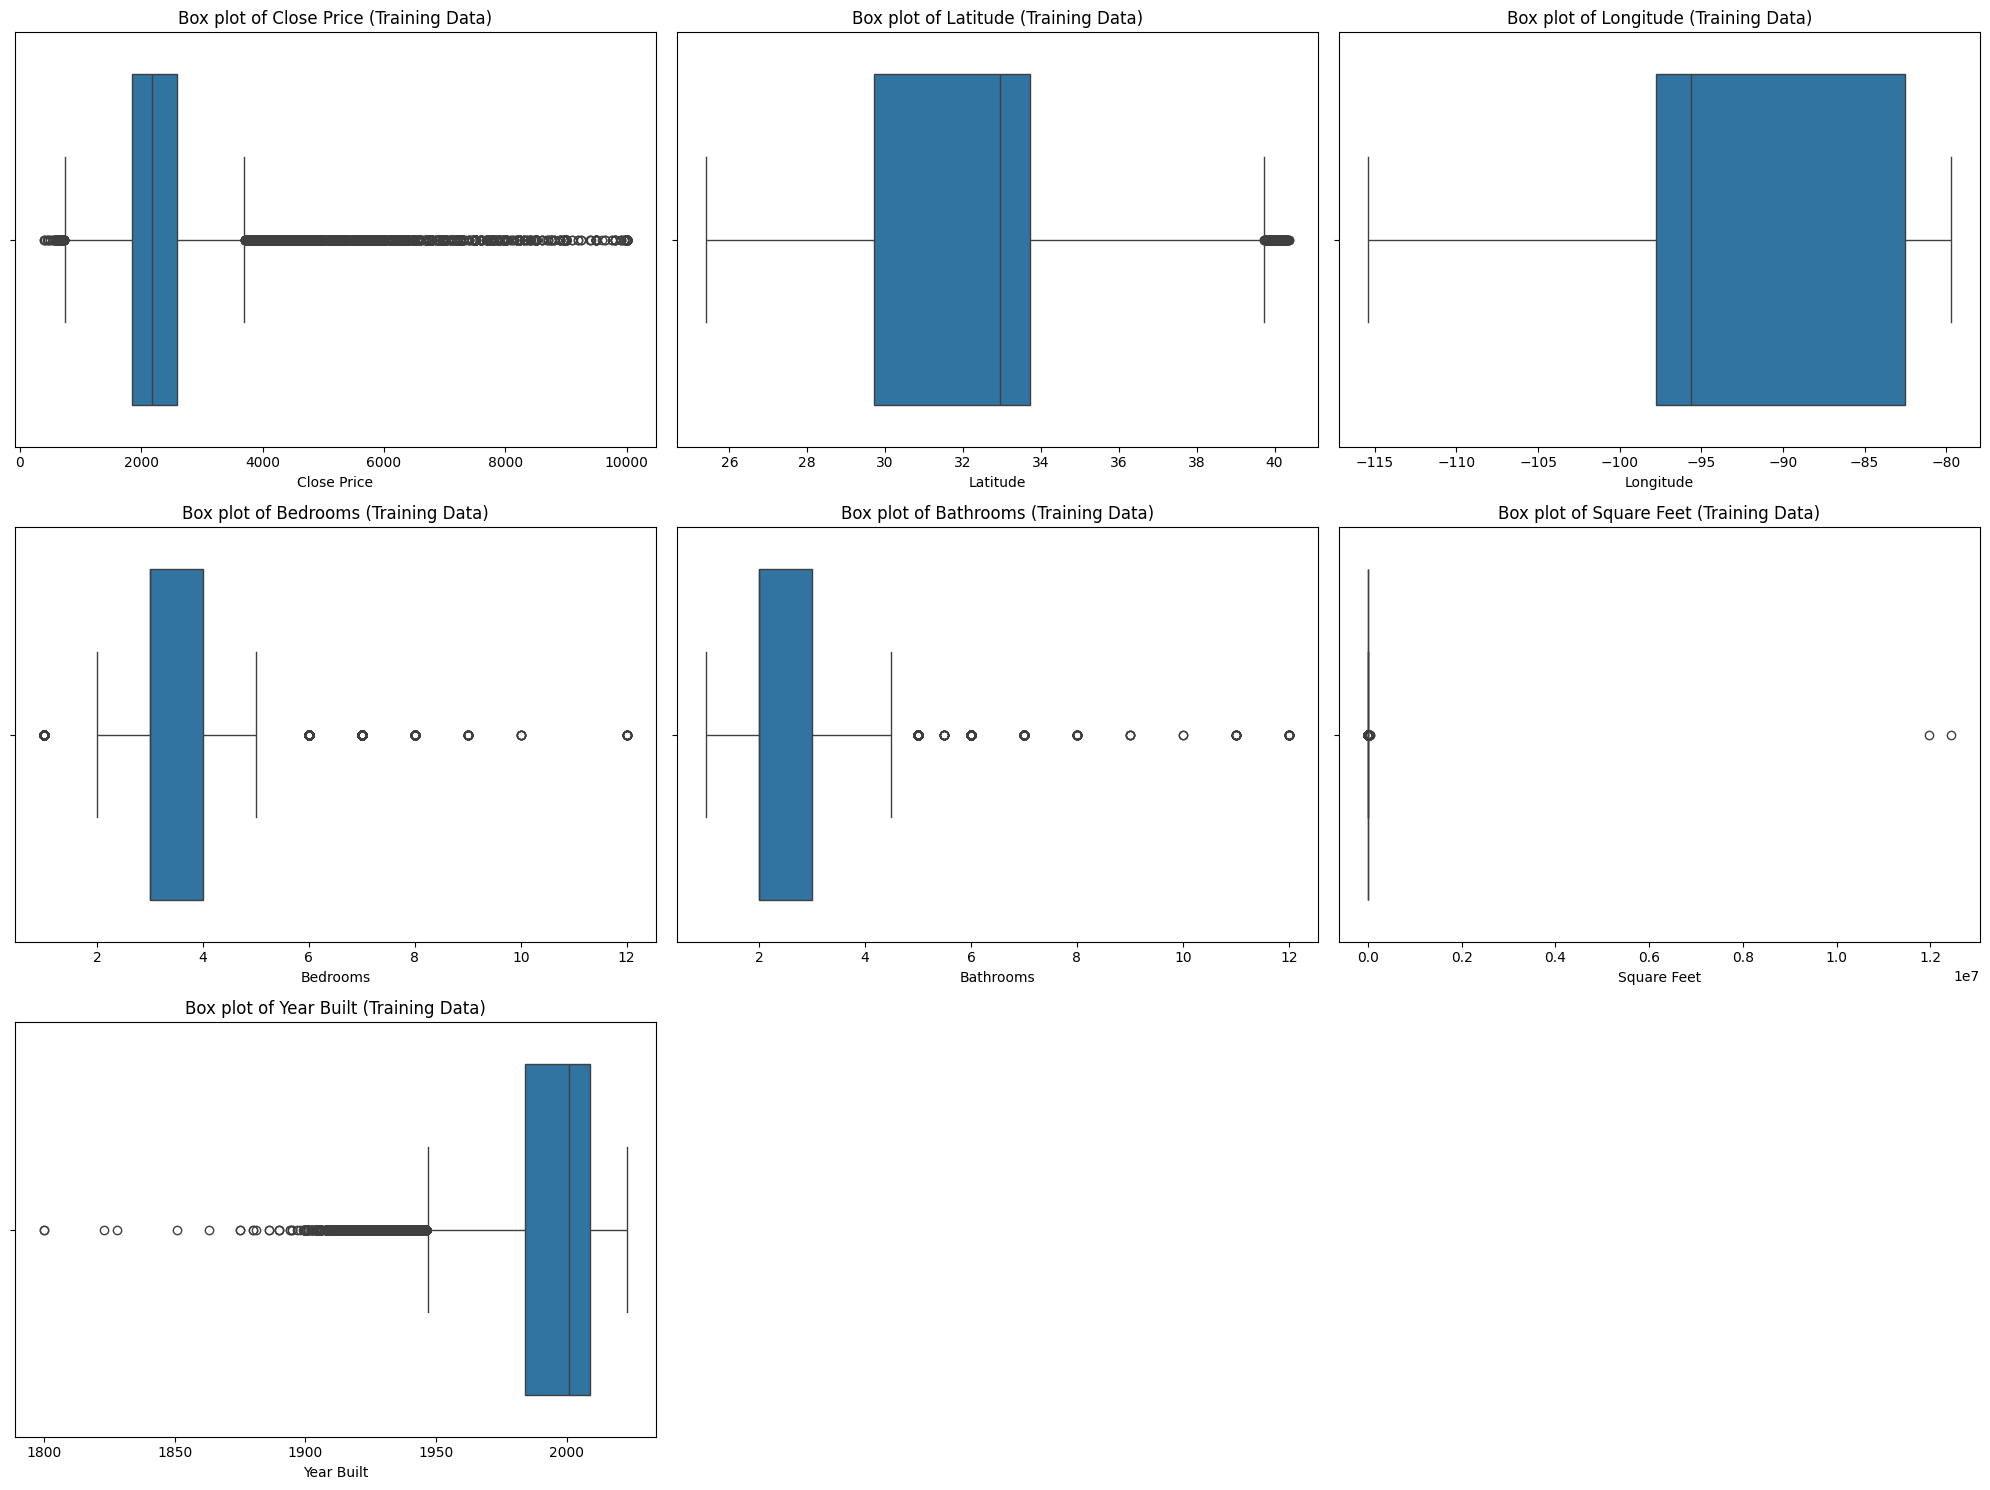

In [ ]:
# Visualize distributions of numerical features in the training data (excluding 'Price per SqFt' for histograms)
numerical_cols_train_hist = ['Close Price', 'Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Square Feet', 'Year Built']
train[numerical_cols_train_hist].hist(bins=50, figsize=(20,15))
plt.suptitle('Distribution of Numerical Features (Training Data)', y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

# Use box plots to visualize potential outliers in the training data (including 'Price per SqFt')
numerical_cols_train_boxplot = ['Close Price', 'Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Square Feet', 'Year Built']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15)) # Adjusted subplot grid for the added column
axes = axes.flatten()

for i, col in enumerate(numerical_cols_train_boxplot):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f'Box plot of {col} (Training Data)')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

In [ ]:
# center of US
#m = folium.Map(location=[39, -98], zoom_start=4)

#for _, row in train.iterrows():
#    folium.CircleMarker(
#        location=[row["Latitude"], row["Longitude"]],
#        radius=3,
#        color="red",
#        fill=True,
#        fill_opacity=0.7
#    ).add_to(m)

#m.save("us_map.html")

In [ ]:
# Download the official TIGER/Line counties shapefile
url = "https://www2.census.gov/geo/tiger/TIGER2024/COUNTY/tl_2024_us_county.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("tl_2024_us_county")   # creates a local folder with .shp

# Load into GeoPandas
counties = gpd.read_file("tl_2024_us_county/tl_2024_us_county.shp").to_crs("EPSG:4326")

train_points = gpd.GeoDataFrame(
    train,
    geometry=gpd.points_from_xy(train["Longitude"], train["Latitude"]),
    crs="EPSG:4326"
)

# spatial join: each point gets the county attrs (NAME, STATEFP, etc.)
train_joined = gpd.sjoin(train_points, counties, how="left", predicate="within")
train_df = train_joined[["Close Date", "Close Price", "Bedrooms", "Bathrooms", "Square Feet", "Year Built", "Latitude", "Longitude", "STATEFP", "COUNTYFP"]]
train_df = train_df.rename(columns={"STATEFP": "State", "COUNTYFP": "County"})

In [ ]:
#take interest rate from web corresponding to the close date month
rates = web.DataReader("FEDFUNDS", 'fred', start='1800-01-01')

# Convert 'Close Date' in train_df to datetime and create a month-start date column
train_df['Close Date'] = pd.to_datetime(train_df['Close Date'])
train_df['Month_Start_Date'] = train_df['Close Date'].dt.to_period('M').dt.to_timestamp()


# Now perform the merge using the new month-start date column
train_rates_df = train_df.merge(rates, left_on='Month_Start_Date', right_index=True, how='left')
train_rates_df = train_rates_df.rename(columns={'FEDFUNDS': 'Interest Rate'})

# Drop the temporary 'Month_Start_Date' column if you don't need it
train_rates_df = train_rates_df.drop(columns=['Month_Start_Date'])

display(train_rates_df)

,Close Date,Close Price,Bedrooms,Bathrooms,Square Feet,Year Built,Latitude,Longitude,State,County,Interest Rate
0,2024-12-17,4800.0,4,3.0,2259,2004,26.257621,-81.711571,12,021,4.48
1,2024-12-17,3700.0,5,6.0,2951,2002,34.041742,-84.044686,13,135,4.48
2,2024-12-17,2400.0,4,2.0,1788,2000,33.205474,-96.664503,48,085,4.48
3,2024-12-17,1770.0,3,1.0,944,1955,27.756995,-82.648477,12,103,4.48
4,2024-12-17,1995.0,3,2.0,1360,2010,32.627490,-97.328963,48,439,4.48
...,...,...,...,...,...,...,...,...,...,...,...
274070,2023-01-19,2475.0,4,3.0,2019,2002,34.182942,-84.590046,13,057,4.33
274071,2023-01-19,1735.0,4,2.0,1995,2014,34.018254,-84.794058,13,223,4.33
274072,2023-01-19,1890.0,4,2.0,1893,2017,33.879067,-84.844168,13,223,4.33
274073,2023-01-19,2030.0,4,3.0,2370,1992,33.698043,-84.764862,13,097,4.33


In [ ]:
#take inflation/CPI from web corresponding to the close date month
start = datetime.datetime(2020,1,1)
end = datetime.datetime.today()

cpi = web.DataReader("CPIAUCSL", "fred", start, end)
cpi = cpi.reset_index()
cpi['year_month'] = cpi['DATE'].dt.to_period('M')
cpi = cpi.rename(columns={'CPIAUCSL': 'CPI'}) # Removed inplace=True

train_rates_df['year_month'] = train_rates_df['Close Date'].dt.to_period('M')
train_cpi_rates_df = train_rates_df.merge(cpi[['year_month', 'CPI']], on='year_month', how='left')

train_cpi_rates_df = train_cpi_rates_df.drop(columns=['year_month'])
train_cpi_rates_df

,Close Date,Close Price,Bedrooms,Bathrooms,Square Feet,Year Built,Latitude,Longitude,State,County,Interest Rate,CPI
0,2024-12-17,4800.0,4,3.0,2259,2004,26.257621,-81.711571,12,021,4.48,317.603
1,2024-12-17,3700.0,5,6.0,2951,2002,34.041742,-84.044686,13,135,4.48,317.603
2,2024-12-17,2400.0,4,2.0,1788,2000,33.205474,-96.664503,48,085,4.48,317.603
3,2024-12-17,1770.0,3,1.0,944,1955,27.756995,-82.648477,12,103,4.48,317.603
4,2024-12-17,1995.0,3,2.0,1360,2010,32.627490,-97.328963,48,439,4.48,317.603
...,...,...,...,...,...,...,...,...,...,...,...,...
249452,2023-01-19,2475.0,4,3.0,2019,2002,34.182942,-84.590046,13,057,4.33,300.456
249453,2023-01-19,1735.0,4,2.0,1995,2014,34.018254,-84.794058,13,223,4.33,300.456
249454,2023-01-19,1890.0,4,2.0,1893,2017,33.879067,-84.844168,13,223,4.33,300.456
249455,2023-01-19,2030.0,4,3.0,2370,1992,33.698043,-84.764862,13,097,4.33,300.456


In [ ]:
# Calculate Price per Square Foot
train_cpi_rates_df['Price per SqFt'] = train_cpi_rates_df['Close Price'] / train_cpi_rates_df['Square Feet']

# Define a function to remove outliers based on IQR within groups
def remove_outliers_by_group(df, group_cols, value_col):
#Removes outliers based on IQR within specified groups.
    cleaned_df = pd.DataFrame()
    for name, group in df.groupby(group_cols):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        filtered_group = group[(group[value_col] >= lower_bound) & (group[value_col] <= upper_bound)]
        cleaned_df = pd.concat([cleaned_df, filtered_group])
    return cleaned_df

# Remove outliers in 'Price per SqFt' grouped by State and County
train_cleaned_df = remove_outliers_by_group(train_cpi_rates_df, ['State', 'County'], 'Price per SqFt')

# Remove rows where Price per SqFt is greater than 4
train_cleaned_df = train_cleaned_df[train_cleaned_df['Price per SqFt'] <= 4]

# Create 'Property Age' feature for the cleaned training data
train_cleaned_df['Property Age'] = 2025 - train_cleaned_df['Year Built']

#SqFt per Bed
train_cleaned_df['SqFt per Bed'] = train_cleaned_df['Square Feet'] / (train_cleaned_df['Bedrooms']+1)

# interest times inflation
train_cleaned_df['Interest_Inflation'] = train_cleaned_df['Interest Rate'] * train_cleaned_df['CPI']

# cluster longitude and latitude
kmeans = KMeans(n_clusters=50, random_state=42, n_init='auto')
train_cleaned_df['Location_Cluster'] = kmeans.fit_predict(
    train_cleaned_df[['Latitude', 'Longitude']]
)

display(train_cleaned_df)

,Close Date,Close Price,Bedrooms,Bathrooms,Square Feet,Year Built,Latitude,Longitude,State,County,Interest Rate,CPI,Price per SqFt,Property Age,SqFt per Bed,Interest_Inflation,Location_Cluster
215885,2023-05-06,700.0,2,3.0,1543,1979,32.521083,-86.382666,01,051,5.06,303.316,0.453662,46,514.333333,1534.77896,25
161150,2023-10-03,2300.0,4,3.0,2309,1970,33.524537,-86.746732,01,073,5.33,307.653,0.996102,55,461.800000,1639.79049,25
195902,2023-07-02,2345.0,4,3.0,2144,2002,33.288810,-86.821406,01,117,5.12,304.615,1.093750,23,428.800000,1559.62880,25
201512,2023-06-19,1825.0,3,2.0,1302,2002,33.279813,-86.851865,01,117,5.08,304.099,1.401690,23,325.500000,1544.82292,25
203692,2023-06-11,1600.0,3,2.0,1429,2007,33.159803,-86.777635,01,117,5.08,304.099,1.119664,18,357.250000,1544.82292,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245847,2023-02-01,1950.0,3,2.0,1674,2021,33.024886,-97.463665,48,497,4.57,301.476,1.164875,4,418.500000,1377.74532,31
246064,2023-02-01,1695.0,3,2.0,1386,2005,33.048615,-97.433364,48,497,4.57,301.476,1.222944,20,346.500000,1377.74532,31
247414,2023-01-25,1595.0,3,2.0,1447,1974,33.010845,-97.440190,48,497,4.33,300.456,1.102281,51,361.750000,1300.97448,31
248317,2023-01-21,2050.0,4,2.0,1826,2021,33.024590,-97.462431,48,497,4.33,300.456,1.122673,4,365.200000,1300.97448,31


Univariate Analysis

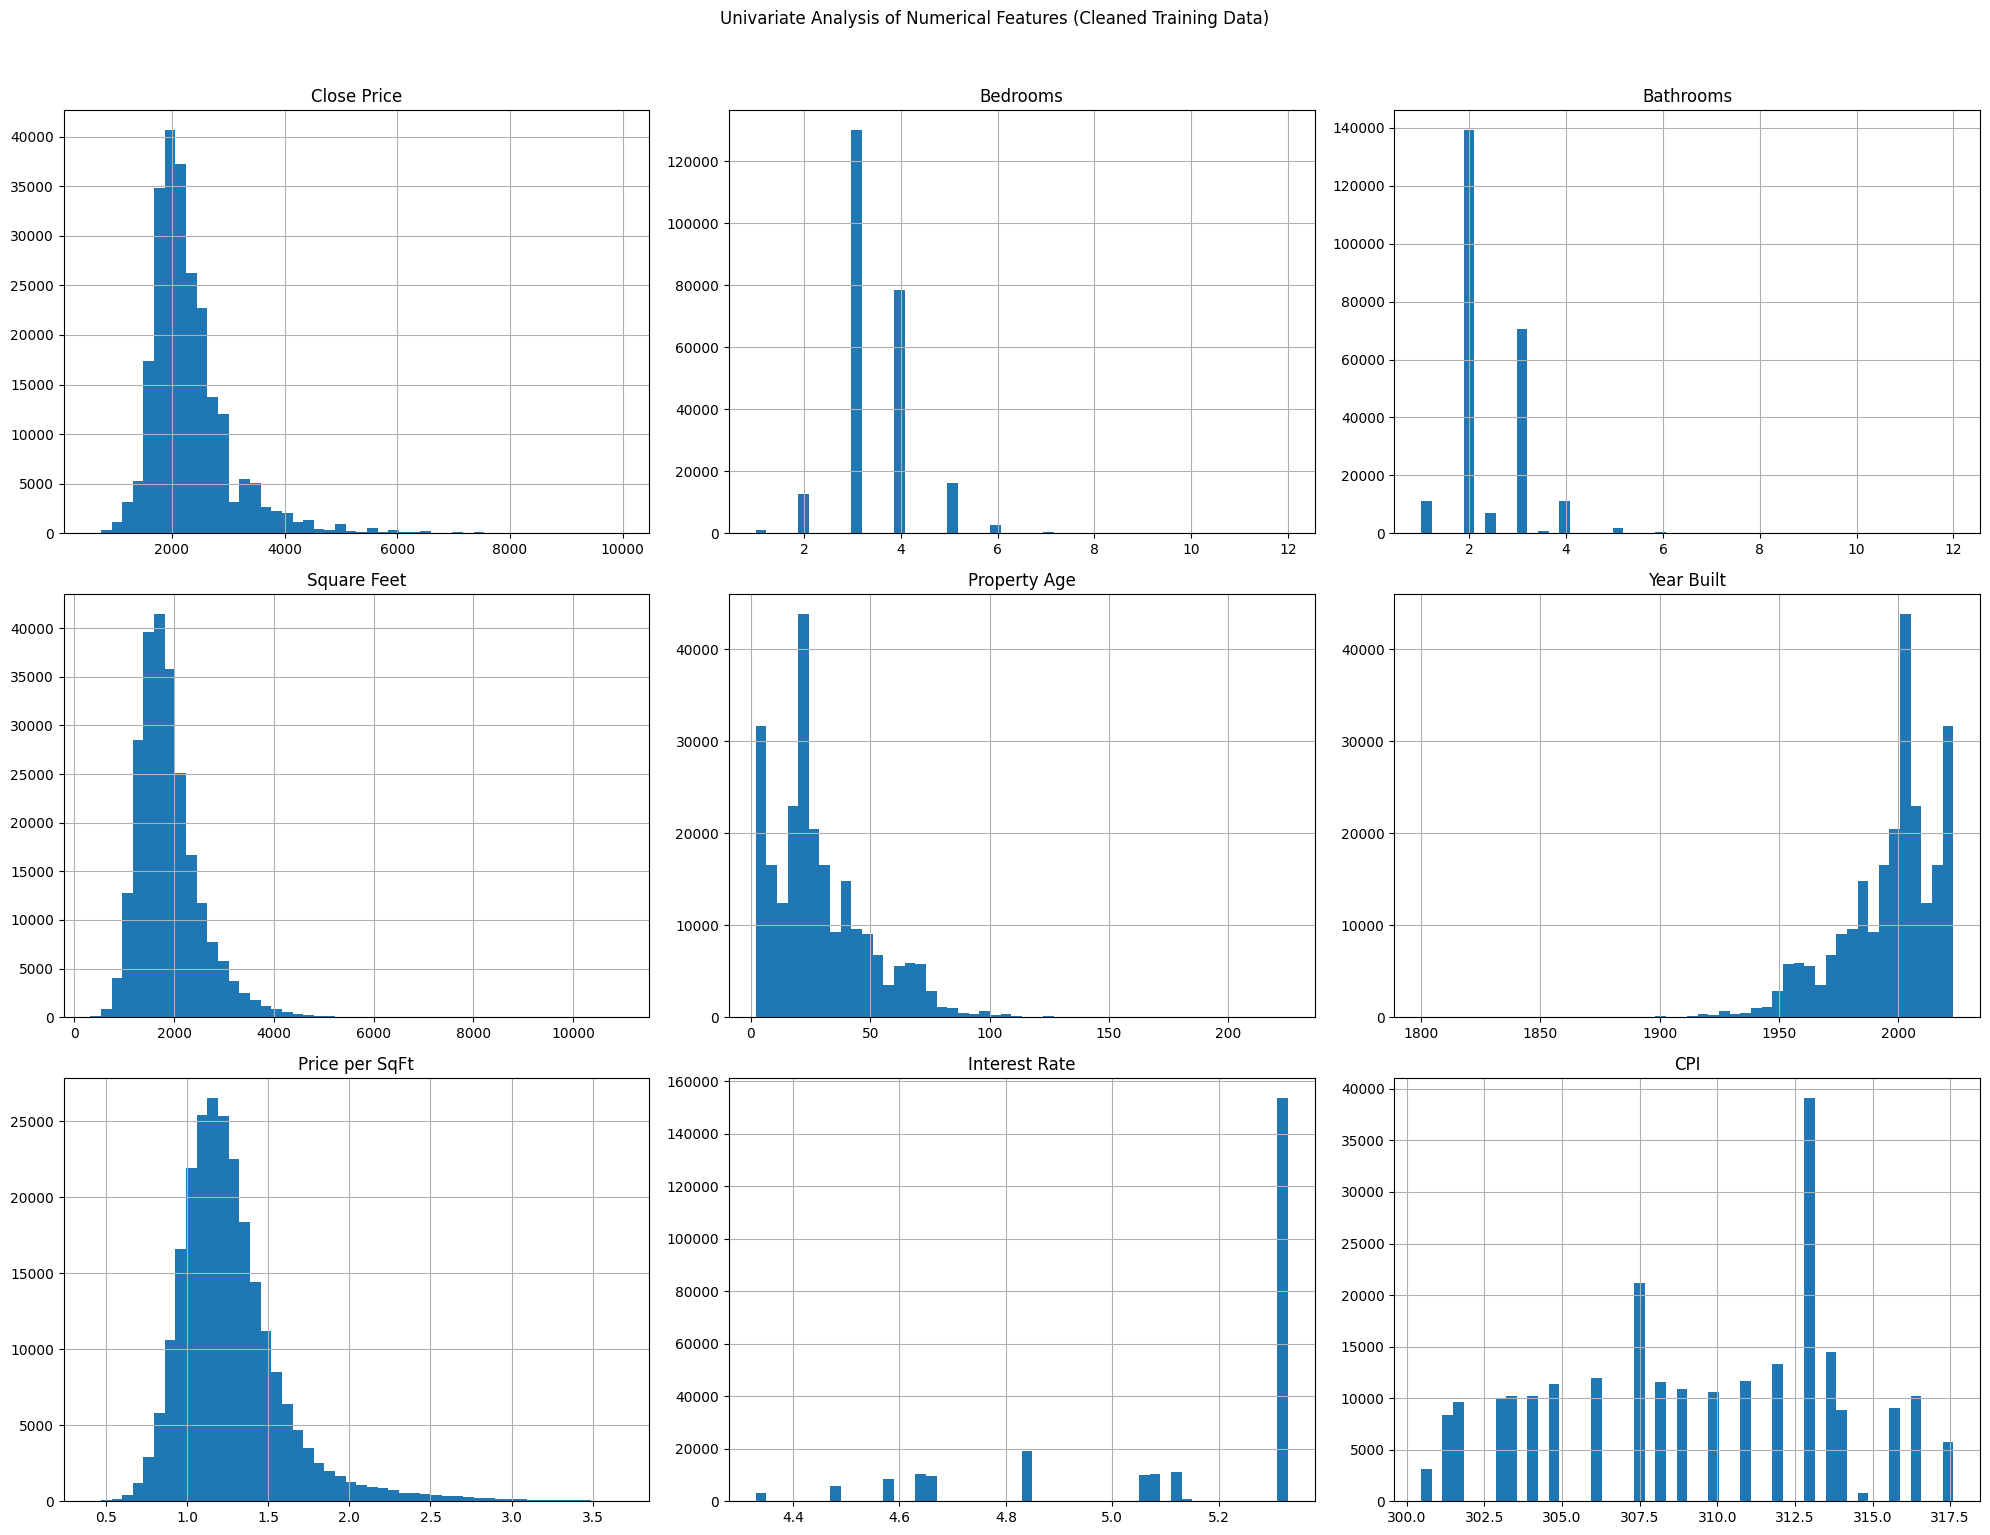


Descriptive statistics for selected numerical features:


,Close Price,Bedrooms,Bathrooms,Square Feet,Property Age,Year Built,Price per SqFt,Interest Rate,CPI
count,242078.000000,242078.000000,242078.000000,242078.000000,242078.000000,242078.000000,242078.000000,242078.000000,242078.000000
mean,2317.202282,3.441870,2.390372,1890.979730,28.785532,1996.214468,1.273194,5.142883,309.312126
std,753.037106,0.789376,0.712652,636.643787,20.271402,20.271402,0.335859,0.284592,4.680720
min,550.000000,1.000000,1.000000,319.000000,2.000000,1800.000000,0.403063,4.330000,300.456000
25%,1850.000000,3.000000,2.000000,1468.000000,15.000000,1985.000000,1.061669,5.060000,304.615000
50%,2165.000000,3.000000,2.000000,1781.000000,24.000000,2001.000000,1.214514,5.330000,309.794000
75%,2550.000000,4.000000,3.000000,2176.000000,40.000000,2010.000000,1.402688,5.330000,313.140000
max,10000.000000,12.000000,12.000000,10993.000000,225.000000,2023.000000,3.684211,5.330000,317.603000


In [ ]:
# Select numerical columns for univariate analysis against Close Price, excluding Latitude and Longitude
univariate_cols = ['Close Price', 'Bedrooms', 'Bathrooms', 'Square Feet', 'Property Age', 'Year Built', 'Price per SqFt', 'Interest Rate', 'CPI']

# Visualize distributions with histograms
train_cleaned_df[univariate_cols].hist(bins=50, figsize=(20,15))
plt.suptitle('Univariate Analysis of Numerical Features (Cleaned Training Data)', y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

#descriptive statistics for these columns
print("\nDescriptive statistics for selected numerical features:")
display(train_cleaned_df[univariate_cols].describe())

Bivariate Analysis

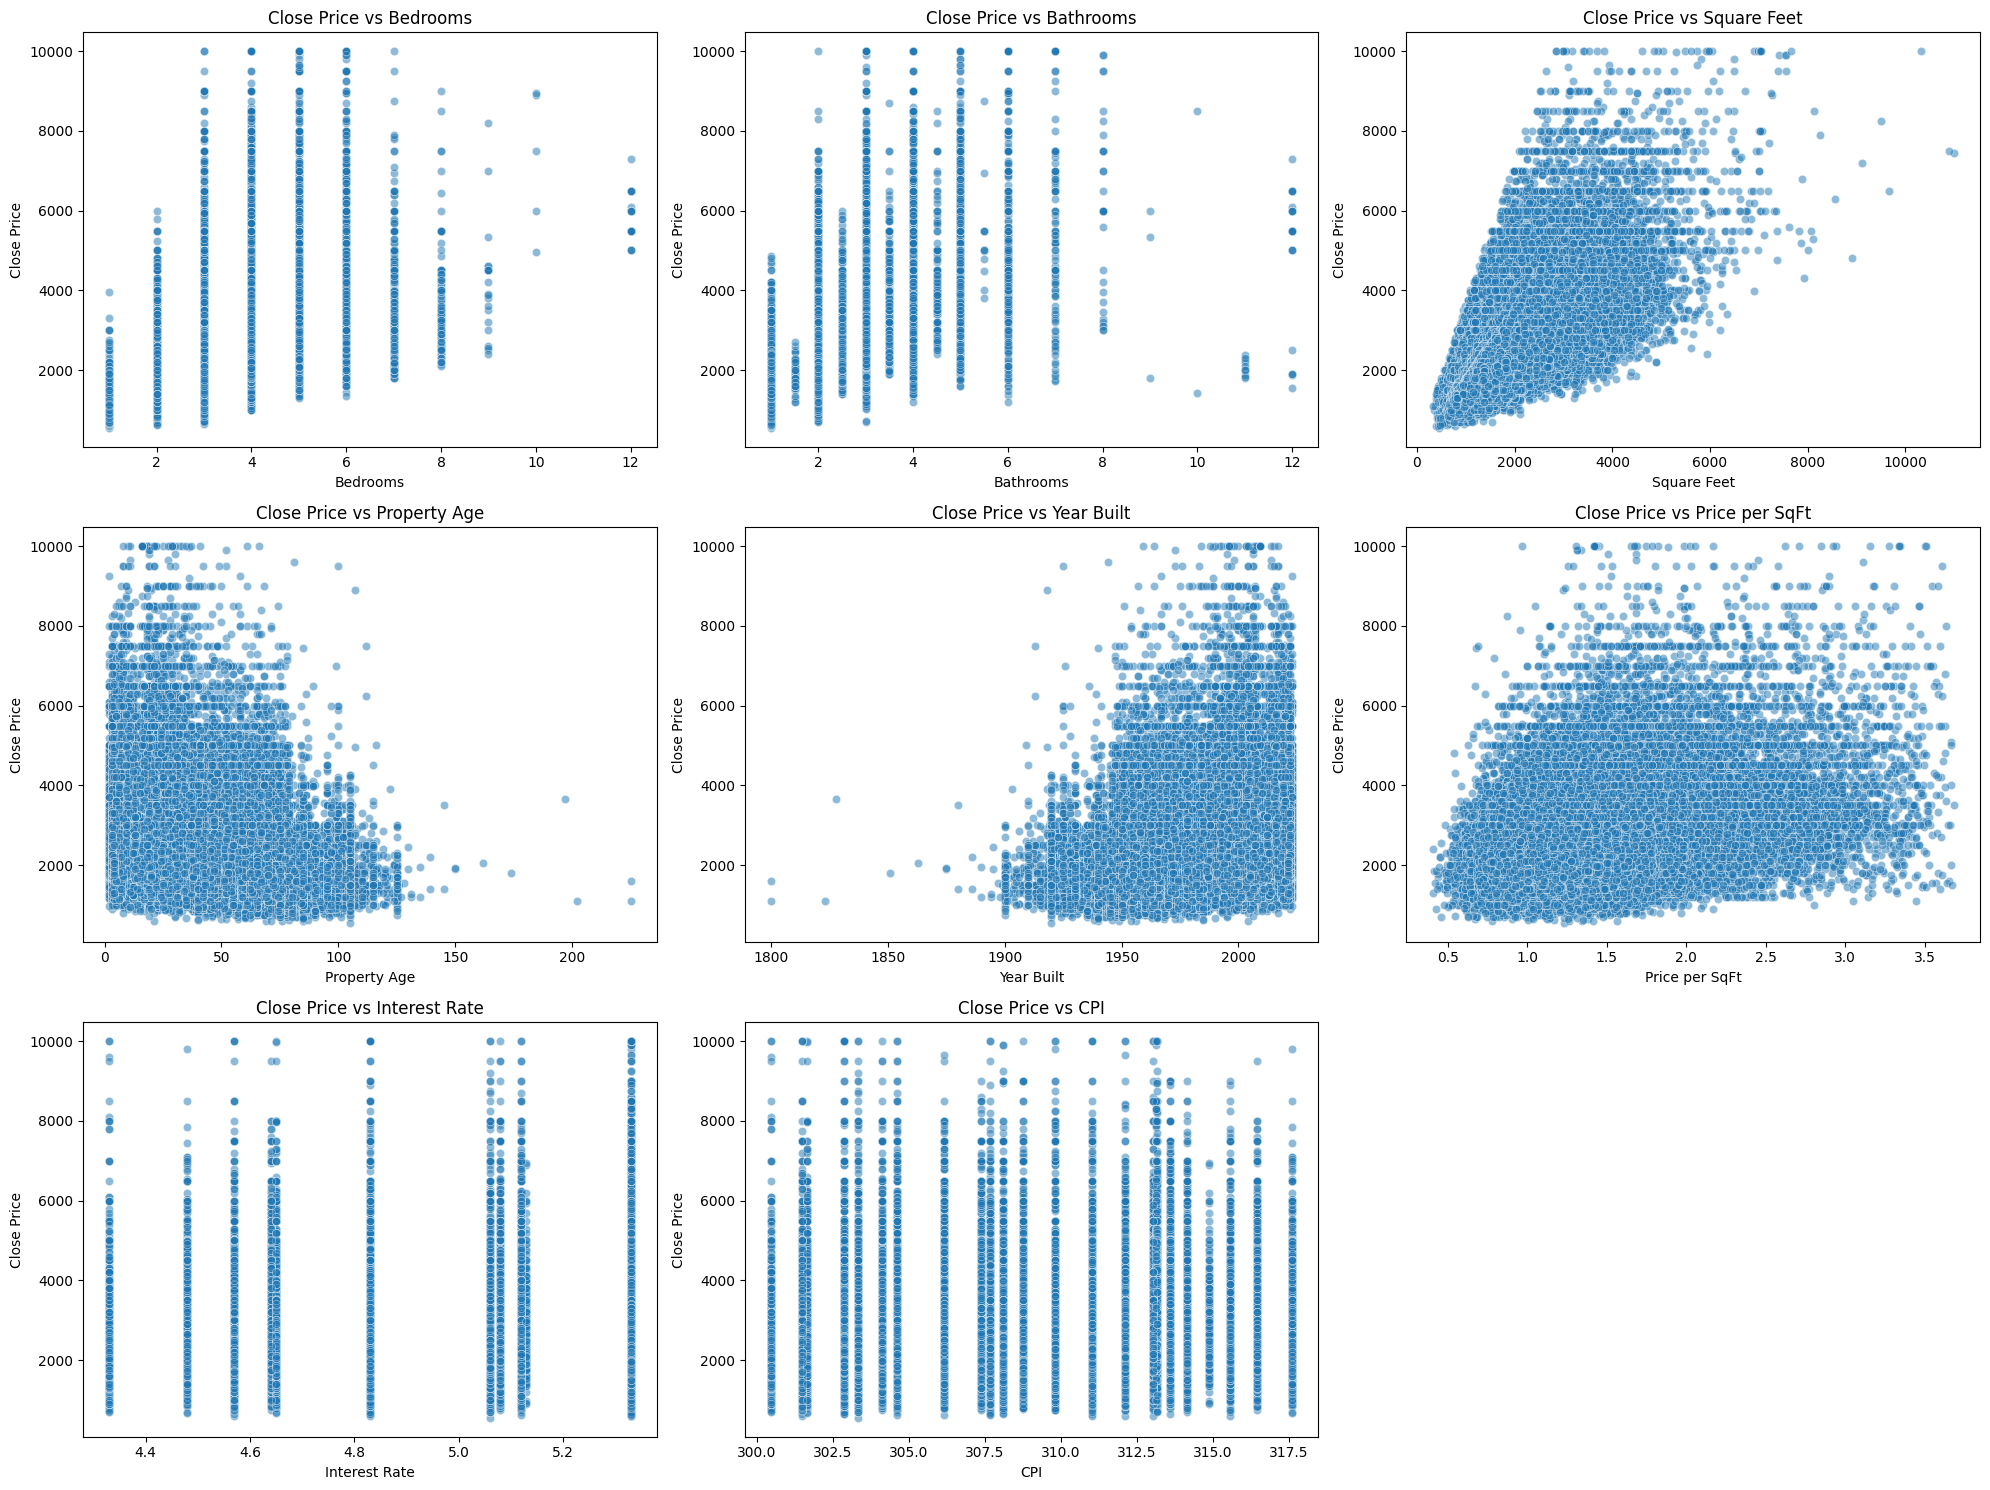

In [ ]:
# Select numerical columns for bivariate analysis against Close Price
bivariate_cols = ['Bedrooms', 'Bathrooms', 'Square Feet', 'Property Age', 'Year Built', 'Price per SqFt', 'Interest Rate', 'CPI']

# Create scatter plots to visualize the relationship between 'Close Price' and other numerical features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(bivariate_cols):
    sns.scatterplot(x=train_cleaned_df[col], y=train_cleaned_df['Close Price'], ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Close Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Close Price')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#perform same transformations onto test set
#counties = gpd.read_file("tl_2024_us_county/tl_2024_us_county.shp").to_crs("EPSG:4326")

#test_points = gpd.GeoDataFrame(
#    test,
#    geometry=gpd.points_from_xy(test["Longitude"], test["Latitude"]),
#    crs="EPSG:4326"
#)

#test_joined = gpd.sjoin(test_points, counties, how="left", predicate="within")
#test_df = test_joined[["Bedrooms", "Bathrooms", "Square Feet", "Year Built", "Latitude", "Longitude", "STATEFP", "COUNTYFP"]]
#test_df = test_df.rename(columns={"STATEFP": "State", "COUNTYFP": "County"})

# Create 'Property Age' feature for the test data based on today's year
#current_year = datetime.date.today().year
#test_df['Property Age'] = current_year - test_df['Year Built']

# Get the most recent Interest Rate (Federal Funds Rate)
#try:
#    # Fetch data starting from an earlier date to ensure we get the latest
#    recent_rates = web.DataReader("FEDFUNDS", 'fred', start='2020-01-01')
#    current_interest_rate = recent_rates['FEDFUNDS'].iloc[-1] # Get the latest available rate
#except Exception as e:
#    print(f"Could not retrieve recent interest rate: {e}")
#    current_interest_rate = 6.22 # Handle cases where data cannot be retrieved


# Get the most recent CPI (Consumer Price Index)
#try:
#    # Fetch data starting from an earlier date to ensure we get the latest
#    recent_cpi = web.DataReader("CPIAUCSL", "fred", start='2020-01-01')
#    current_cpi_value = recent_cpi['CPIAUCSL'].iloc[-1] # Get the latest available CPI
#except Exception as e:
#    print(f"Could not retrieve recent CPI: {e}")
#    current_cpi_value = 324.368 # Handle cases where data cannot be retrieved


# Add the most recent Interest Rate and CPI as columns to the test DataFrame
#test_df['Interest Rate'] = current_interest_rate
#test_df['CPI'] = current_cpi_value

#drop price per sqft due to high correlation to target
train_cleaned_df = train_cleaned_df.drop(columns=['Price per SqFt'])

#print("Processed Test Data with most recent Interest Rate and CPI:")
#display(test_df.head())
#print("\nCleaned Training Data:")
#display(train_cleaned_df.head())

Model Preparation

In [ ]:
#X = train_cleaned_df.drop(columns=['Close Price', 'Close Date']) # Yield R-sq=80%, MAE = 216
#y = train_cleaned_df['Close Price']

#use log on sqft and close price to stabilize skewed distributions and reduce outlier impact
train_cleaned_df['Log_SquareFeet'] = np.log1p(train_cleaned_df['Square Feet'])

feature_cols = [
    'Bedrooms',
    'Bathrooms',
    'Property Age',
    'Log_SquareFeet',
    'Interest Rate',
    'CPI',
    'Interest_Inflation',
    'Latitude',
    'Longitude',
    'Location_Cluster',
    'SqFt per Bed'
]

X = train_cleaned_df[feature_cols]
y = np.log1p(train_cleaned_df['Close Price'])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
#determine best random forest parameters
#def objective_rf(trial):
#    n_estimators = trial.suggest_int("n_estimators", 200, 800)
#    max_depth = trial.suggest_int("max_depth", 6, 20)
#    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
#    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
#    max_features = trial.suggest_categorical("max_features", ["sqrt", 0.7]) # Changed 'auto' to 'sqrt'

#    model = RandomForestRegressor(
#        n_estimators=n_estimators,
#        max_depth=max_depth,
#        min_samples_split=min_samples_split,
#        min_samples_leaf=min_samples_leaf,
#       max_features=max_features,
#       n_jobs=-1,
#       random_state=42
#    )

   # negative MAPE/MAE/R2 etc. – here we use R2
#    scores = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1)
#    return scores.mean()

#study_rf = optuna.create_study(direction="maximize")
#study_rf.optimize(objective_rf, n_trials=30)   # run more trials if you want

#print("Best RF params:", study_rf.best_params)
#print("Best RF score:", study_rf.best_value)

[I 2025-11-09 13:25:03,778] A new study created in memory with name: no-name-398005e8-17a5-40c7-ad0e-989452436949
[I 2025-11-09 13:25:52,633] Trial 0 finished with value: 0.509221614268708 and parameters: {'n_estimators': 529, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.509221614268708.
[I 2025-11-09 13:28:09,158] Trial 1 finished with value: 0.5242346527830625 and parameters: {'n_estimators': 364, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.7}. Best is trial 1 with value: 0.5242346527830625.
[I 2025-11-09 13:29:42,719] Trial 2 finished with value: 0.5461218310864607 and parameters: {'n_estimators': 502, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5461218310864607.
[I 2025-11-09 13:30:12,702] Trial 3 finished with value: 0.5233646042082065 and parameters: {'n_estimators': 302, 'max_depth': 8, 'min_sam

Best RF params: {'n_estimators': 402, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best RF score: 0.5465331852714391


In [ ]:
#determine best XGBoost parameters
#def objective_xgb(trial):
#    params = {
#        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
#        "max_depth": trial.suggest_int("max_depth", 3, 10),
#        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
#       "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#       "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
#        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
#       "random_state": 42,
#        "n_jobs": -1,
#    }
#    model = XGBRegressor(**params)
#    scores = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1)
#    return scores.mean()

#study_xgb = optuna.create_study(direction="maximize")
#study_xgb.optimize(objective_xgb, n_trials=30)

#print("Best XGB params:", study_xgb.best_params)

[I 2025-11-09 14:17:09,723] A new study created in memory with name: no-name-c9b41b29-754f-4ab8-a7c7-e7bfb991a086
[I 2025-11-09 14:17:18,644] Trial 0 finished with value: 0.5045567119109163 and parameters: {'n_estimators': 466, 'max_depth': 8, 'learning_rate': 0.011848038929232951, 'subsample': 0.7318158132998407, 'colsample_bytree': 0.827187990444465, 'min_child_weight': 10, 'reg_lambda': 0.048857766787424886, 'reg_alpha': 6.9874779245510705}. Best is trial 0 with value: 0.5045567119109163.
[I 2025-11-09 14:17:29,791] Trial 1 finished with value: 0.5096448405852528 and parameters: {'n_estimators': 671, 'max_depth': 9, 'learning_rate': 0.08901835464039262, 'subsample': 0.806619220277347, 'colsample_bytree': 0.8083615427069559, 'min_child_weight': 8, 'reg_lambda': 0.024669865450584073, 'reg_alpha': 9.292655701917877}. Best is trial 1 with value: 0.5096448405852528.
[I 2025-11-09 14:17:33,731] Trial 2 finished with value: 0.45874371408728826 and parameters: {'n_estimators': 423, 'max_dep

Best XGB params: {'n_estimators': 799, 'max_depth': 10, 'learning_rate': 0.042890539494477055, 'subsample': 0.9902378340640587, 'colsample_bytree': 0.8370349734101322, 'min_child_weight': 10, 'reg_lambda': 0.018226161892281684, 'reg_alpha': 0.7061842750662458}


In [ ]:
#def objective_gb(trial):
#    params = {
#        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
#        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#        "max_depth": trial.suggest_int("max_depth", 2, 8),
#        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
#        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
#        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
#        "random_state": 42,
#    }

#    model = GradientBoostingRegressor(**params)
#    scores = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1)
#    return scores.mean()


#study_gb = optuna.create_study(direction="maximize", study_name="GB")
#study_gb.optimize(objective_gb, n_trials=30)
#print("Best GB params:", study_gb.best_params)
#print("Best GB R2:", study_gb.best_value)

[I 2025-11-09 14:27:46,667] A new study created in memory with name: GB
[I 2025-11-09 14:29:43,605] Trial 0 finished with value: 0.437568730050473 and parameters: {'n_estimators': 665, 'learning_rate': 0.06149394881141008, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 11, 'subsample': 0.6628771390489081, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.437568730050473.
[I 2025-11-09 14:30:20,145] Trial 1 finished with value: 0.4828985853363979 and parameters: {'n_estimators': 505, 'learning_rate': 0.021449372522498553, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.9307335549403932, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.4828985853363979.
[I 2025-11-09 14:31:41,669] Trial 2 finished with value: 0.36368540559391355 and parameters: {'n_estimators': 360, 'learning_rate': 0.15600955449249196, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 8, 'subsample': 0.9316946739882414, 'max_features': 'sqrt'}. Best is tri

Best GB params: {'n_estimators': 140, 'learning_rate': 0.019091675031561, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 20, 'subsample': 0.6003327927755666, 'max_features': 'sqrt'}
Best GB R2: 0.5284974800044623


In [ ]:
#def objective_lgb(trial):
#    params = {
#        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
#        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
#        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
#        "max_depth": trial.suggest_int("max_depth", -1, 12),
#       "min_child_samples": trial.suggest_int("min_child_samples", 10, 80),
#       "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
#        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
#        "random_state": 42,
#        "n_jobs": -1,
#    }

#    model = LGBMRegressor(**params)
#    scores = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1)
#    return scores.mean()


#study_lgb = optuna.create_study(direction="maximize", study_name="LGBM")
#study_lgb.optimize(objective_lgb, n_trials=30)
#print("Best LGBM params:", study_lgb.best_params)
#print("Best LGBM R2:", study_lgb.best_value)

In [ ]:
#def objective_cat(trial):
#    params = {
#        "iterations": trial.suggest_int("iterations", 400, 1200),
#        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
#        "depth": trial.suggest_int("depth", 4, 10),
#        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
#        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 5.0),
#        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
#        "loss_function": "RMSE",
#        "random_state": 42,
#        "verbose": 0,
#    }

#    model = CatBoostRegressor(**params)
#    scores = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1)
#    return scores.mean()


#study_cat = optuna.create_study(direction="maximize", study_name="CAT")
#study_cat.optimize(objective_cat, n_trials=30)
#print("Best CAT params:", study_cat.best_params)
#print("Best CAT R2:", study_cat.best_value)

[I 2025-11-09 17:37:15,264] A new study created in memory with name: CAT
[I 2025-11-09 17:37:54,439] Trial 0 finished with value: 0.5250060263926796 and parameters: {'iterations': 949, 'learning_rate': 0.019635944269311253, 'depth': 8, 'l2_leaf_reg': 5.419165716236144, 'bagging_temperature': 3.5913745026857082, 'random_strength': 0.2679196702059079}. Best is trial 0 with value: 0.5250060263926796.
[I 2025-11-09 17:38:09,711] Trial 1 finished with value: 0.5239924514641016 and parameters: {'iterations': 420, 'learning_rate': 0.06314789706285345, 'depth': 7, 'l2_leaf_reg': 2.611279967060848, 'bagging_temperature': 1.2315058770212595, 'random_strength': 1.7685567432338494}. Best is trial 0 with value: 0.5250060263926796.
[I 2025-11-09 17:38:28,408] Trial 2 finished with value: 0.4965116740937325 and parameters: {'iterations': 435, 'learning_rate': 0.016898881099867667, 'depth': 8, 'l2_leaf_reg': 5.985306176014667, 'bagging_temperature': 0.14283662240724304, 'random_strength': 0.1684213205

Best CAT params: {'iterations': 1169, 'learning_rate': 0.011211390733013313, 'depth': 10, 'l2_leaf_reg': 9.828169962269168, 'bagging_temperature': 1.2717102364897532, 'random_strength': 1.1380810477637486}
Best CAT R2: 0.5403610948391698


In [ ]:
#take best hypertuning parameters
best_rf = RandomForestRegressor(n_estimators= 402,
                                max_depth= 13,
                                min_samples_split= 10,
                                min_samples_leaf= 2,
                                max_features= 'sqrt')

best_xgb = XGBRegressor(n_estimators= 799,
                        max_depth= 10,
                        learning_rate= 0.042890539494477055,
                        subsample= 0.9902378340640587,
                        colsample_bytree= 0.8370349734101322,
                        min_child_weight= 10,
                        reg_lambda= 0.018226161892281684,
                        reg_alpha= 0.7061842750662458)

best_gb = GradientBoostingRegressor(n_estimators= 140,
                                    learning_rate= 0.019091675031561,
                                    max_depth= 8,
                                    min_samples_split= 9,
                                    min_samples_leaf= 20,
                                    subsample= 0.6003327927755666,
                                    max_features= 'sqrt')

best_lgb = LGBMRegressor(n_estimators= 366,
                         learning_rate= 0.02351071641139739,
                         num_leaves= 122,
                         max_depth= -1,
                         min_child_samples= 55,
                         subsample= 0.8310066258513371,
                         colsample_bytree= 0.9580134674832063,
                         reg_alpha= 0.03803688988733922,
                         reg_lambda= 0.004072968764454005)

best_cat = CatBoostRegressor(iterations= 1169,
                             learning_rate= 0.011211390733013313,
                             depth= 10,
                             l2_leaf_reg= 9.828169962269168,
                             bagging_temperature= 1.2717102364897532,
                             random_strength= 1.1380810477637486)

#use Linear Regression, Random Forest, Gradient Boosting, XGBoost, Light GBM, Cat Boost Models
lr = LinearRegression()
rf = best_rf
gb = best_gb
xgb = best_xgb
lgb = best_lgb
cat = best_cat

models = [("Linear", lr), ("RandomForest", rf), ("GradientBoost", gb), ("XGB", xgb), ('LGB', lgb), ('CAT', cat)]

#show all model results separately
for name, model in models:
    model.fit(X_train, y_train)
    preds = np.expm1(model.predict(X_val)) # Apply inverse transformation
    print(f"{name}: R²={r2_score(np.expm1(y_val), preds):.3f}, MAE={mean_absolute_error(np.expm1(y_val), preds):.2f}") # Evaluate on original scal

Linear: R²=0.550, MAE=337.71
RandomForest: R²=0.765, MAE=236.24
GradientBoost: R²=0.740, MAE=245.90
XGB: R²=0.814, MAE=203.92
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 193662, number of used features: 11
[LightGBM] [Info] Start training from score 7.706834
LGB: R²=0.801, MAE=212.25
0:	learn: 0.2761878	total: 78.9ms	remaining: 1m 32s
1:	learn: 0.2742456	total: 110ms	remaining: 1m 3s
2:	learn: 0.2722873	total: 146ms	remaining: 56.9s
3:	learn: 0.2703456	total: 177ms	remaining: 51.6s
4:	learn: 0.2684847	total: 206ms	remaining: 48s
5:	learn: 0.2665988	total: 241ms	remaining: 46.7s
6:	learn: 0.2647528	total: 276ms	remaining: 45.8s
7:	learn: 0

In [ ]:
#Stack Ensemble with 6 models for greater accuracy
stack = StackingRegressor(
    estimators=[
        ('lr', lr),
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('gb', best_gb),
        ('lgb', best_lgb),
        ('cat', best_cat),
    ],
    final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0, 50.0]),
    n_jobs=-1
)

stack.fit(X_train, y_train)

stack_preds = np.expm1(stack.predict(X_val))
y_val_real = np.expm1(y_val)

#Stack Ensemble R-sq and MAE
r2 = r2_score(y_val_real, stack_preds)
mae = mean_absolute_error(y_val_real, stack_preds)
print(f"Stacking Ensemble R²: {r2:.4f}")
print(f"Stacking Ensemble MAE: {mae:.2f}")

#cross-validation for reliability
cv_r2 = cross_val_score(stack, X, y, cv=5, scoring='r2')
print(f"Cross-validated R²: {cv_r2.mean():.4f} ± {cv_r2.std():.3f}")

Stacking Ensemble R²: 0.8142
Stacking Ensemble MAE: 203.89
Cross-validated R²: 0.6417 ± 0.051


In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.01, 100.0, log=True)

    final_est = RidgeCV(alphas=[alpha])

    stack = StackingRegressor(
        estimators=[
            ('lr', lr),
            ('rf', best_rf),
            ('xgb', best_xgb),
            ('gb', best_gb),
            ('lgb', best_lgb),
            ('cat', best_cat),
        ],
        final_estimator=final_est,
        n_jobs=-1
    )

    # 3-fold CV on the *log* target
    scores = cross_val_score(
        stack, X, y,
        cv=3,
        scoring='r2',
        n_jobs=-1
    )
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

print("Best params:", study.best_params)
print("Best R² (CV):", study.best_value)

[I 2025-11-09 20:07:08,872] A new study created in memory with name: no-name-d9503e39-db39-4b17-8267-4b26aab12719
[I 2025-11-09 20:36:31,962] Trial 0 finished with value: 0.535550309709968 and parameters: {'alpha': 3.0168486678986137}. Best is trial 0 with value: 0.535550309709968.
[I 2025-11-09 21:06:41,807] Trial 1 finished with value: 0.5341299526184778 and parameters: {'alpha': 0.13344732834245007}. Best is trial 0 with value: 0.535550309709968.
[I 2025-11-09 21:37:18,023] Trial 2 finished with value: 0.5372801330020881 and parameters: {'alpha': 17.796165257591834}. Best is trial 2 with value: 0.5372801330020881.
[I 2025-11-09 22:05:44,238] Trial 3 finished with value: 0.5349438159714006 and parameters: {'alpha': 0.888306719888889}. Best is trial 2 with value: 0.5372801330020881.
[W 2025-11-09 22:32:23,425] Trial 4 failed with parameters: {'alpha': 9.739788429947028} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/pytho

KeyboardInterrupt: 

In [ ]:
best_alpha = study.best_params['alpha']

final_stack = StackingRegressor(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('gb', best_gb),
        ('lgb', best_lgb),
        ('cat', best_cat),
    ],
    final_estimator=RidgeCV(alphas=[best_alpha]),
    n_jobs=-1
)

final_stack.fit(X_train, y_train)
final_preds = np.expm1(final_stack.predict(X_val))
print("Final R²:", r2_score(np.expm1(y_val), final_preds))
print("Final MAE:", mean_absolute_error(np.expm1(y_val), final_preds))

final_r2 = cross_val_score(stack, X, y, cv=5, scoring='r2')
print(f"Cross-validated R²: {final_r2.mean():.4f} ± {final_r2.std():.3f}")

In [ ]:
#final_model = stack #best model
#final_model.fit(X, y)  # retrain on all available data

In [ ]:
joblib.dump(stack, "market_rent_model_compressed.pkl", compress=3)

#X_loc = train_cleaned_df[['Latitude', 'Longitude']]
#kmeans = KMeans(n_clusters=50, random_state=42, n_init='auto')
#kmeans.fit(X_loc)
#joblib.dump(kmeans, "kmeans_model.pkl")

['market_rent_model_compressed.pkl']

In [ ]:
import pandas as pd
import numpy as np
import requests
import io
import joblib
import datetime

MODEL_URL = "https://raw.githubusercontent.com/AlphaCurse/Market_Rent_Calc/main/model/market_rent_model_compressed.pkl"
KMEANS_URL = "https://raw.githubusercontent.com/AlphaCurse/Market_Rent_Calc/main/model/kmeans_model.pkl"

def _load_pickle_from_github(url: str):
    resp = requests.get(url)
    resp.raise_for_status()
    return joblib.load(io.BytesIO(resp.content))

def calculate_market_rent(df: pd.DataFrame) -> pd.DataFrame:
#    df must have at least:
#      ['Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Square Feet', 'Year Built']
    # load artifacts
    model = _load_pickle_from_github(MODEL_URL)
    kmeans = _load_pickle_from_github(KMEANS_URL)

    df = df.copy()

    # feature engineering
    # property age
    current_year = datetime.date.today().year
    df["Property Age"] = current_year - df["Year Built"]

    # log sqft
    df["Log_SquareFeet"] = np.log1p(df["Square Feet"])

    # sqft per bed
    df["SqFt per Bed"] = df["Square Feet"] / (df["Bedrooms"] + 1)

    # hardcode int rate and CPI
    df["Interest Rate"] = 5.33
    df["CPI"] = 313.0
    df["Interest_Inflation"] = df["Interest Rate"] * df["CPI"]

    # location cluster from lat/long with the SAME kmeans
    df["Location_Cluster"] = kmeans.predict(df[["Latitude", "Longitude"]])

    #select features
    feature_cols = [
        "Bedrooms",
        "Bathrooms",
        "Property Age",
        "Log_SquareFeet",
        "Interest Rate",
        "CPI",
        "Interest_Inflation",
        "Latitude",
        "Longitude",
        "Location_Cluster",
        "SqFt per Bed",
    ]

    # model was trained on log target, so inverse-transform
    preds_log = model.predict(df[feature_cols])
    df["Market Rent"] = np.expm1(preds_log)

    return df